XGBoost의 scikit-learn 래퍼 클래스의 주요 하이퍼파라미터

- n_estimators: 부스트 트리의 개수를 결정합니다. 너무 큰 값은 오버피팅을 유발할 수 있습니다.
- learning_rate (eta): 각 트리의 가중치를 줄이는 역할을 합니다. 일반적으로 더 낮은 학습률은 더 많은 트리를 필요로 합니다.
- learning_rate (eta): 각 부스팅 단계 축소를 제어합니다. 이는 새로운 트리가 추가될 때 각각에 부여되는 가중치를 조정하는 데 사용되며, 일반적으로 0과 1 사이의 값을 가집니다. 이 값이 낮을수록 모델은 보수적으로 학습하며, 이는 더 많은 부스팅 단계를 필요로 할 수 있습니다. 이 값이 높을수록 모델은 더욱 강하게 학습하지만, 너무 높은 값은 오버피팅을 초래할 수 있습니다.
- max_depth: 각 트리의 최대 깊이를 결정합니다. 이 값이 크면 모델은 복잡해지고 오버피팅 될 수 있습니다.
- min_child_weight: 트리에서 가지를 분할하기 위한 최소 가중치 합입니다. 이 값이 크면 모델은 보수적으로 학습합니다.
- subsample: 각 트리를 훈련시키기 위해 사용하는 데이터 샘플의 비율입니다. 이 값이 작으면 오버피팅을 피하는 데 도움이 될 수 있습니다.
- colsample_bytree: 각 트리를 훈련시키는 데 사용되는 열(특성)의 비율입니다.
- gamma: 리프 노드를 추가적으로 분할할 최소 손실 감소입니다. 이 값이 높을수록 모델은 보수적으로 학습합니다.
- reg_lambda (lambda): L2 정규화 가중치입니다.
- reg_alpha (alpha): L1 정규화 가중치입니다

- 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화(plotting) 기능을 가지고 있음
- 조기 중단 기능으로 부스팅 반복 횟수에 도달하지 않더라도 더 이상 예측 오류가 개선되지 않으면 반복을 중지해 수행 시간을 개선하는 기능도 있음
- 병렬 처리 기능

- XGBoost 버전 확인

In [1]:
!pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 5.6 MB/s eta 0:00:00


In [2]:
import xgboost

xgboost.__version__

'1.7.5'

### 파이썬 래퍼 XGBoost 적용-위스콘신 유방암 예측

In [3]:
import xgboost as xgb
from xgboost import plot_importance       # 피처의 중요도를 시각화해주는 모듈
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target
cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [4]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
# 악성, 양성

print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [6]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼러미 Label임, Feature용 DataFrame은 cancer_df의 첫 번째 칼럼에서 맨 마지막 두 번째 칼럼까지를 :-1
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
# (XGBooster가 제공하는 기능인 검증 성능 평가와 조기 중단을 수행해 보기 위함)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)
print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [7]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,\
f1_score,roc_auc_score 

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬:\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))    

In [9]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬:
 [[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


early_stopping_rounds
- XGBoost의 하이퍼파라미터는 아니지만, 학습 과정을 제어하는 중요한 매개변수 중 하나입니다. 이 매개변수는 validation set에 대한 모델의 성능이 개선되지 않을 경우 학습을 조기 종료하는 데 사용
- 설정한 라운드 수만큼 동안 검증 오차(validation error)가 감소하지 않을 경우에 학습이 조기에 중지됩니다. 이는 더 이상 학습이 진전되지 않거나 오버피팅이 시작되는 것을 방지하는 데 도움

eval_metric은 XGBoost 모델을 학습하면서 사용할 평가 지표를 지정하는 매개변수 (뭘 기준으로 스탑할거냐)
- rmse: Root Mean Square Error
- mae: Mean Absolute Error
- logloss: Negative log-likelihood
- error: Binary classification error rate (0.5 threshold)
- auc: Area under the curve for both binary and multiclass classification
- mlogloss: Multiclass logloss
- merror: Multiclass classification error rate

In [10]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]

# 10일 때
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

# 100일 때
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[177]	validation_0-logloss:0.08705
[178]	validation_0-logloss:0.08697
[179]	validation_0-logloss:0.08697
[180]	validation_0-logloss:0.08704
[181]	validation_0-logloss:0.08680
[182]	validation_0-logloss:0.08683
[183]	validation_0-logloss:0.08658
[184]	validation_0-logloss:0.08659
[185]	validation_0-logloss:0.08661
[186]	validation_0-logloss:0.08637
[187]	validation_0-logloss:0.08637
[188]	validation_0-logloss:0.08630
[189]	validation_0-logloss:0.08610
[190]	validation_0-logloss:0.08602
[191]	validation_0-logloss:0.08605
[192]	validation_0-logloss:0.08615
[193]	validation_0-logloss:0.08592
[194]	validation_0-logloss:0.08591
[195]	validation_0-logloss:0.08598
[196]	validation_0-logloss:0.08601
[197]	validation_0-logloss:0.08592
[198]	validation_0-logloss:0.08585
[199]	validation_0-logloss:0.08587
[200]	validation_0-logloss:0.08589
[201]	validation_0-logloss:0.08595
[202]	validation_0-logloss:0.08573
[203]	validation_0-logloss:0.08573
[204]	validation_0-logloss:0.08575
[205]	validation_0-l

In [12]:
lidation_0-logloss:0.08571
[210]	validation_0-logloss:0.08581

SyntaxError: illegal target for annotation (3917092116.py, line 1)

In [13]:
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬:
 [[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9947
오차 행렬:
 [[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

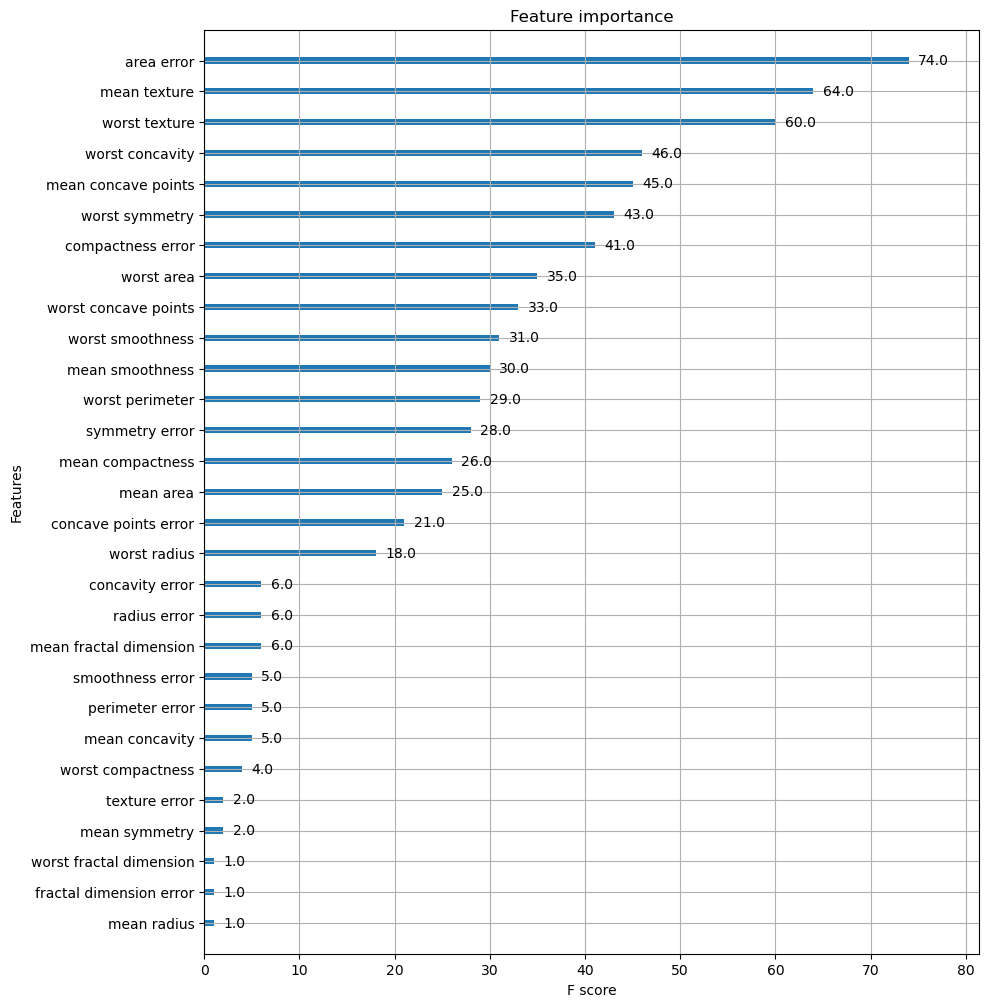

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

베이지안 조건부 확률 공부
하이퍼 파라미터 튜닝하는 gradient?는 시간 많이 걸림 큰 데이터에 -> 베이지안이 그래서 효과적임